In [3]:
import os 
os.chdir("..")
print(os.getcwd())

import numpy as np

from utils.load_confs import load_parameters, load_paths

params = load_parameters()
paths = load_paths()

/u/clw4542/research/rl_ifo_mujoco


In [4]:
RESULTS_DIR = "/scratch/cluster/clw4542/ridm_results/"
ENV_ID = "Ant-v2" # timesteps 3e6, log interval = 100
# Reacher-v2: timesteps = 75k
ENV_LIST = ["Reacher-v2", "Swimmer-v2", "Ant-v2", 
            "HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"
           ]

### Train Baseline SAC 

In [21]:
! python -m src.expert_traj.train_sample_sac --task train --env_id $ENV_ID

KeyboardInterrupt: 

### Get Demonstrations 

In [16]:
! python -m src.expert_traj.train_sample_sac --task sample --env_id $ENV_ID

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

### Plot Results

In [5]:
from collections import deque 
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# version for reading stable baselines logs 
def read_learning_data(log_path:str):
    mean_ep_rets = []
    std_ep_rets = []
    ts_so_far = []
    ep_idx = 0 
    ret_buffer = deque(maxlen=100)
    for summary in tf.train.summary_iterator(log_path):
        for v in summary.summary.value:
            if v.tag == 'episode_reward':
                ep_idx += 1
                ret_buffer.append(v.simple_value)
                if ep_idx % 50 == 0:
                    mean_ep_rets.append(np.mean(ret_buffer))
                    std_ep_rets.append(np.std(ret_buffer))
                    timestep = summary.step
                    ts_so_far.append(timestep)        
    return ts_so_far, mean_ep_rets, std_ep_rets

def read_eval_data(log_path:str):
    eval_data = np.load(os.path.join(log_path, "evaluations.npz"))
    #     eval_data = np.load("/scratch/cluster/clw4542/ridm_results/baseline_rl/log/sac_Reacher-v2_2/evaluations.npz")
    ts = eval_data["timesteps"]
    results = eval_data["results"]
    mean = np.mean(results, axis=1)[:,0]
    std = np.std(results, axis=1)[:,0]
    return ts, mean, std
    
def plot_algo_with_demo(logs_dict, algo, env, eval_mode=False):
    '''the result should be a tuple of 2 lists, representing the x and y coords to plot'''
    # TODO: Add lines representing expert and random performance
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for label, result in logs_dict.items():
        time_idx, mean, std = result
        ax.plot(time_idx, mean, label=label)
        std = np.array(std)
#         ax.errorbar(time_idx, mean, yerr=std, label=label)
        # for light orange, use #FF9848
        ax.fill_between(time_idx, mean-std/2, mean+std/2,
                        alpha=0.5, edgecolor='#089FFF', facecolor='#089FFF' # light blue 
                       )

    ax.legend(fontsize=14)
    mode = "eval" if eval_mode else "learn"
    ax.set_title(f"{algo} on {env} (mode={mode})", fontsize=20)
    if eval_mode: 
        ax.set_ylabel("Mean Ep Rets \n(avg over 5 eps)", fontsize=16)
    else: 
        ax.set_ylabel("Mean Ep Rets", fontsize=16)
    ax.set_xlabel("Timesteps", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

    plt.show()
    plt.close()

def newest(path):
    '''Returns full path of newest file in given path'''
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [178]:
# ! ls -l /scratch/cluster/clw4542/ridm_results/baseline_rl_hidden=64/log
! du -sh /scratch/cluster/clw4542/ridm_results/ridm_original_init
# ! cat /scratch/cluster/clw4542/ridm_results/baseline_rl_hidden=64/ppo2_Walker2d_83508_4294967294.out
# ! ls -l /scratch/cluster/clw4542/ridm_results/baseline_rl/checkpoint

# ! rm -r /scratch/cluster/clw4542/ridm_results/baseline_rl_hidden=64/log/ppo2_Walker2d-v2_1

35G	/scratch/cluster/clw4542/ridm_results/ridm_original_init


### SAC

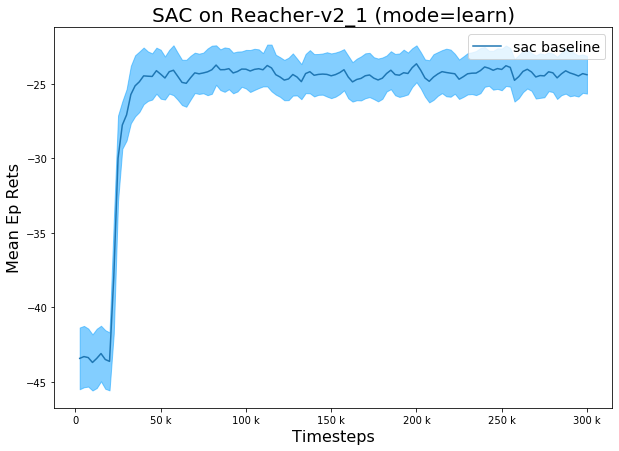

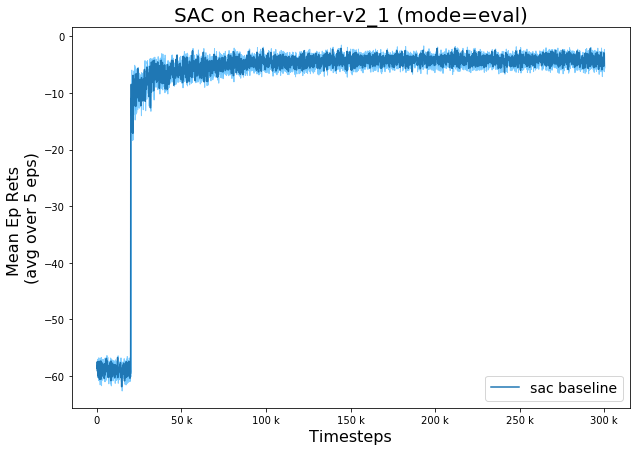

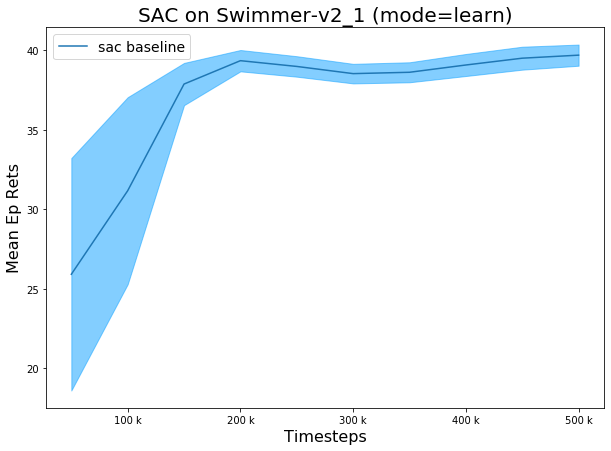

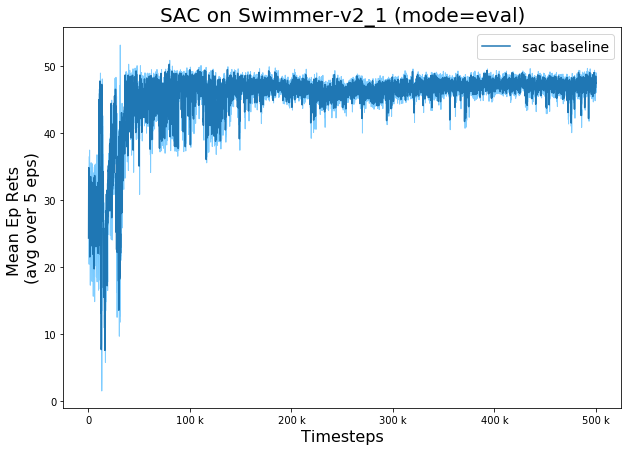

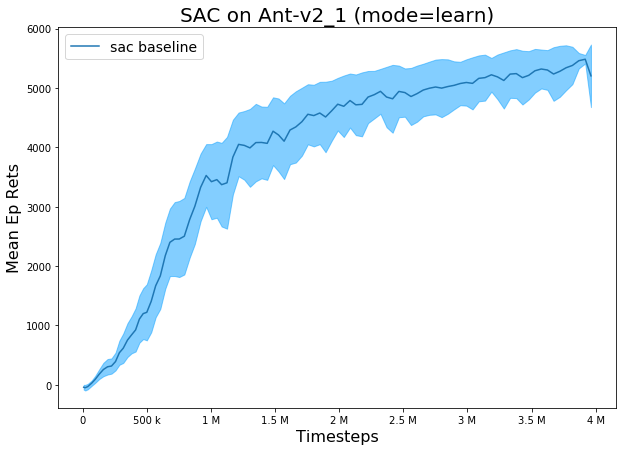

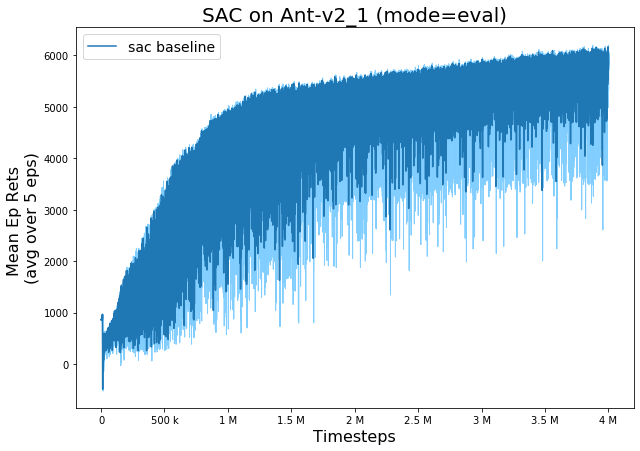

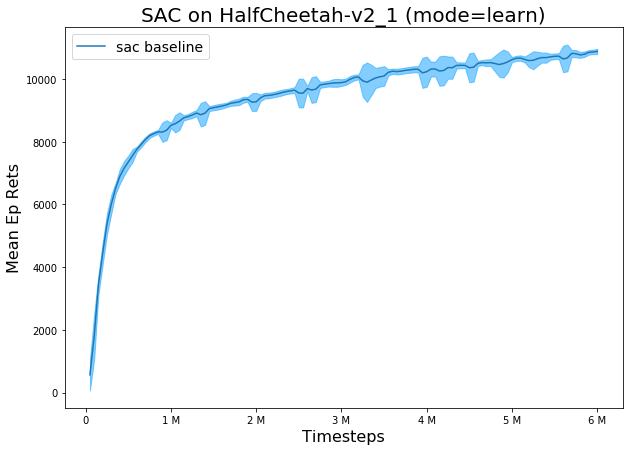

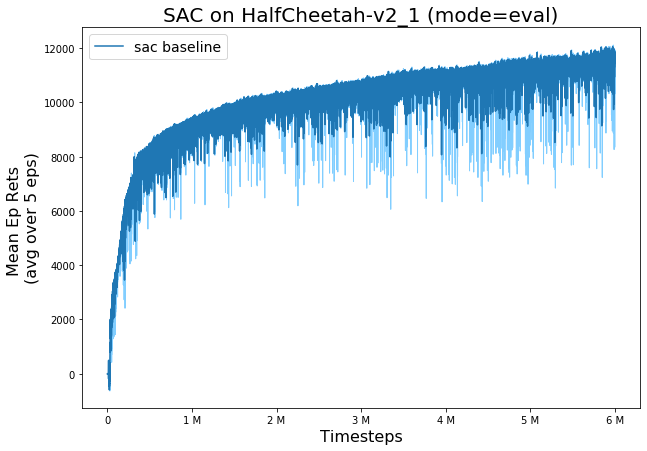

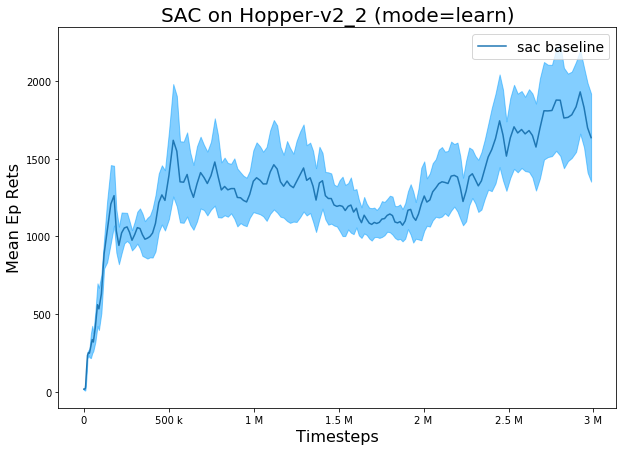

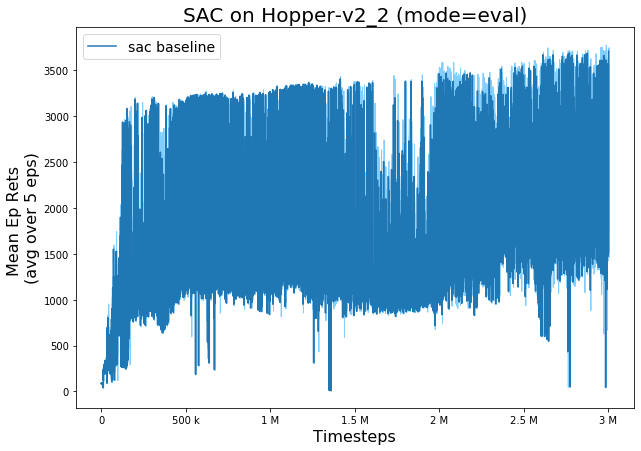

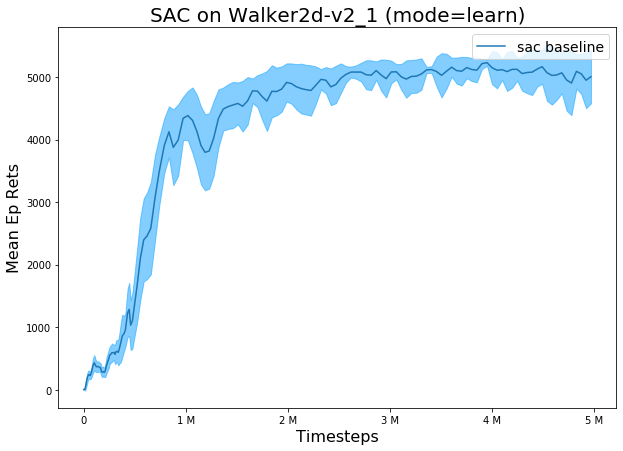

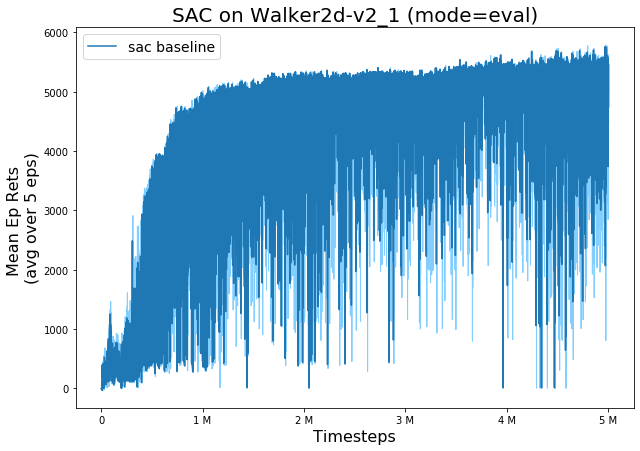

In [142]:
algo = "sac"
for env_id in [
                "Reacher-v2_1",
                "Swimmer-v2_1",
                "Ant-v2_1",
                "HalfCheetah-v2_1",
                "Hopper-v2_2", 
                "Walker2d-v2_1"
              ]:
    logs_dict = {
                f"{algo} baseline": read_learning_data(newest(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}/")),
# #                 f"{algo} w/raw demo": read_learning_data(newest(f"{RESULTS_DIR}/raw_demo_aug_rl/log/{algo}_{env_id}")),
# #                 f"{algo} w/full demo": read_learning_data(newest(f"{RESULTS_DIR}/full_demo_aug_rl/log/{algo}_{env_id}")),
# #                 f"{algo} w/state model": read_learning_data(newest(f"{RESULTS_DIR}/aux_state_model_rl/log/{algo}_{env_id}"))  
                }
    eval_data_dict = {
                    f"{algo} baseline": read_eval_data(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}/"),        
                     }
    plot_algo_with_demo(logs_dict, algo=algo.upper(), env=env_id)
    plot_algo_with_demo(eval_data_dict, algo=algo.upper(), env=env_id, eval_mode=True)


### PPO2

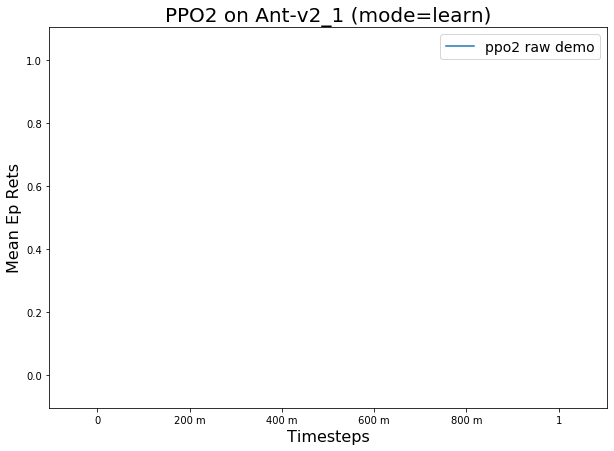

In [17]:
algo = "ppo2" 
for env_id in [ 
#                 "Reacher-v2_1", #ppo2 NEWEST, rlzoo env 
#                 "Swimmer-v2_1", # ppo2
                "Ant-v2_1", #ppo2
#                 "HalfCheetah-v2_1",
#                 "Walker2d-v2_2",
#                 "Hopper-v2_1"
]:
    logs_dict = {
#                 f"{algo} baseline": read_learning_data(newest(f"{RESULTS_DIR}/baseline_rl_hidden=64/log/{algo}_{env_id}/")),
                f"{algo} raw demo": read_learning_data(newest(f"{RESULTS_DIR}/raw_noisy_demo_rl_displace-t=1_demo=sac/log/{algo}_{env_id}/")),        
#                 f"{algo} full demo": read_learning_data(newest(f"{RESULTS_DIR}/full_demo_aug_rl_displace-t=1/log/{algo}_{env_id}/")),        
#                 f"{algo} time feat": read_learning_data(newest(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}/")),        
#                 f"{algo} time feat+raw_demo": read_learning_data(newest(f"{RESULTS_DIR}/raw_demo_time_feat_rl_time_feat_displace-t=1/log/{algo}_{env_id}/")),        
#                 f"{algo} time feat+full_demo": read_learning_data(newest(f"{RESULTS_DIR}/full_demo_time_feat_rl_displace-t=1/log/{algo}_{env_id}/")),        
                }
    plot_algo_with_demo(logs_dict, algo=algo.upper(), env=env_id)


In [173]:
total_timesteps = 2e6
n_envs = 2
n_steps = 2048
n_batch = n_envs * n_steps
n_updates = total_timesteps // n_batch
n_updates

488.0

In [ ]:
! ls /scratch/cluster/clw4542/ridm_results//raw_demo_aug_rl_displace-t=1_demo=sac_norm=True

In [9]:
algo = "ppo2"
for env_id in [
#                 "Reacher-v2_1", #ppo2 NEWEST, rlzoo env 
#                 "Swimmer-v2_1", # ppo2
                "Ant-v2_1", #ppo2
#                 "HalfCheetah-v2_1",
#                 "Walker2d-v2_2",
#                 "Hopper-v2_1"
            ]:
    eval_data_dict = {
                    f"{algo} baseline": read_eval_data(f"{RESULTS_DIR}/baseline_rl_hidden=64/log/{algo}_{env_id}/"),        
                    f"{algo} raw demo": read_eval_data(f"{RESULTS_DIR}/raw_demo_aug_rl_displace-t=1/log/{algo}_{env_id}/"),        
                    f"{algo} full demo": read_eval_data(f"{RESULTS_DIR}/full_demo_aug_rl_displace-t=1/log/{algo}_{env_id}/"),        
#                     f"{algo} time feat": read_eval_data(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}/"),        
#                     f"{algo} time feat+raw_demo": read_eval_data(f"{RESULTS_DIR}/raw_demo_time_feat_rl_time_feat_displace-t=1/log/{algo}_{env_id}/"),        
#                     f"{algo} time feat+full_demo": read_eval_data(f"{RESULTS_DIR}/full_demo_time_feat_rl_displace-t=1/log/{algo}_{env_id}/"),        

    }
    plot_algo_with_demo(eval_data_dict, algo=algo.upper(), env=env_id, eval_mode=True )


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/ridm_results//raw_demo_aug_rl_displace-t=1/log/ppo2_Ant-v2_1/evaluations.npz'